In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from scipy.signal import convolve2d
from tqdm import tqdm
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
})

In [2]:
def generate_random_cells(n, alpha=.2):
    return np.random.uniform(0, 1, size=(n,n)) <= alpha

def step(X):
    live_neighbors = count_live_neighbors(X)
    survive_underpopulation = live_neighbors >= 2
    survive_overpopulation = live_neighbors <= 3
    survive = X * survive_underpopulation * survive_overpopulation
    new_status = np.where(live_neighbors==3, True, survive)  # Reproduce
    return new_status

def count_live_neighbors(status):
    """Counts the number of neighboring live cells"""
    kernel = np.array(
        [[1, 1, 1],
         [1, 0, 1],
         [1, 1, 1]]
    )
    c = convolve2d(status, kernel, mode='same', boundary="wrap")
    return c


def play_life(X, t=1):
    for i in range(t):
        X = step(X)

    return X

def show_image(X):
    X = 1-X
    plt.imshow(X, cmap='gray')
    plt.show()


def generate_dataset_for_step(N, size, steps=1, alpha=.7):
    inputs = np.empty((N, size,size))
    outputs = np.empty((N, size, size))
    for i in range(N):
        inputs[i] = generate_random_cells(size, alpha)
        outputs[i] = play_life(inputs[i], steps)

    return inputs, outputs

In [3]:
inputs, outputs = generate_dataset_for_step(100000, 32, 1, alpha=.1)
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)
class Step1Dataset(Dataset):
    def __init__(self, inputs, labels):
        self.data = inputs
        self.targets = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.targets[idx].unsqueeze(0)
train_batch = 128
test_batch = 128

dataset = Step1Dataset(inputs, outputs)
train, test = random_split(dataset, [int(len(dataset)*.8), len(dataset) - int(len(dataset)*.8)]) # split data 80/20
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=test_batch, drop_last=True)
print('Trainloader length:', len(train_loader))
print('Testloader length:', len(test_loader))  

Trainloader length: 625
Testloader length: 156


In [4]:
class SimpleConv(nn.Module):
    def __init__(self):
        super(SimpleConv, self).__init__()

        self.net = nn.Sequential(nn.Conv2d(1, 512, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(512, 256, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(256, 128, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(128, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(64, 128, 3, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(128, 256, 3, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(256, 1, 3, padding=1),
                    )

    def forward(self, x):
        return self.net(x)




In [ ]:
model = SimpleConv().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.MSELoss()
num_epochs = 5
loop = tqdm(total=len(train_loader) * num_epochs, position=0)
test_losses = []
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for batch, (x, y_truth) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        train_losses.append(loss.item())
        
        accuracy = torch.sum(torch.where(torch.where(y_hat > .5, 1, 0) == y_truth, 1, 0) / torch.numel(y_truth))
        train_accuracy.append(accuracy.cpu().detach().numpy())
        if batch == 0:
            test_loss = []
            test_acc = []
            for val_x, val_y in test_loader:
                val_x, val_y = val_x.cuda(), val_y.cuda()
                y_pred = model(val_x)
                test_loss.append(objective(y_pred, val_y).item())
                test_acc.append(torch.sum(torch.where(torch.where(y_pred > .5, 1, 0) == val_y, 1, 0) / torch.numel(val_y)).cpu().detach().numpy())
            test_losses.append(np.mean(test_loss))
            test_accuracy.append(np.mean(test_acc))

        loop.set_description('train loss: {:.4f}, train accuracy:{:.4f}, test loss: {:.4f}, test acc: {:.4f}'.format(loss.item(), accuracy, test_losses[-1], test_accuracy[-1]))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()

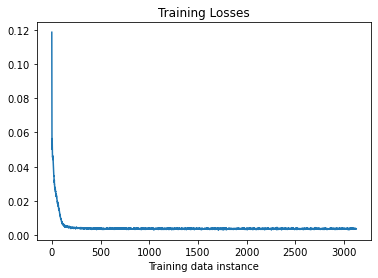

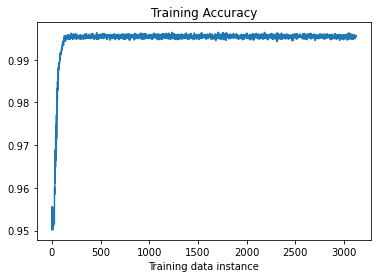

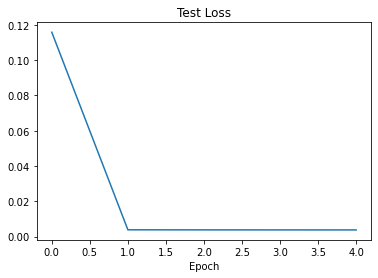

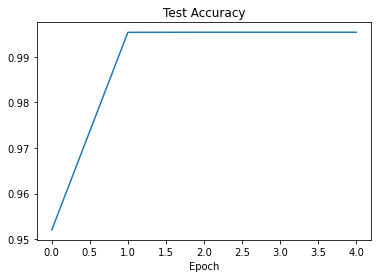

In [5]:
plt.plot(train_losses)
plt.title('Training Losses')
plt.xlabel('Training data instance')
plt.show()
plt.plot(train_accuracy)
plt.xlabel('Training data instance')
plt.title('Training Accuracy')
plt.show()
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel("Epoch")
plt.show()
plt.plot(test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

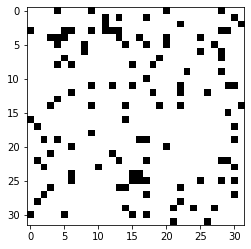

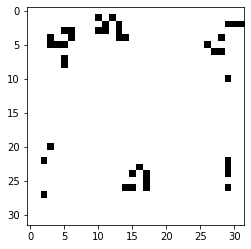

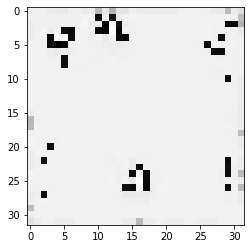

In [6]:
input, output = test[10]
input, output = input.unsqueeze(0).cuda(), output.unsqueeze(0).cuda()

gen_output = model(input)

input, output, gen_output = input.squeeze().cpu().detach().numpy(), output.squeeze().cpu().detach().numpy(), gen_output.squeeze().cpu().detach().numpy()
show_image(input)
show_image(output)
show_image(gen_output)

In [7]:
inputs, outputs = generate_dataset_for_step(100000, 32, 10, alpha=.5)
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)
class Step10Dataset(Dataset):
    def __init__(self, inputs, labels):
        self.data = inputs
        self.targets = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.targets[idx].unsqueeze(0)
train_batch = 128
test_batch = 128

dataset = Step10Dataset(inputs, outputs)
train, test = random_split(dataset, [int(len(dataset)*.8), len(dataset) - int(len(dataset)*.8)]) # split data 80/20
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=test_batch, drop_last=True)
print('Trainloader length:', len(train_loader))
print('Testloader length:', len(test_loader)) 

Trainloader length: 625
Testloader length: 156


In [8]:
model = SimpleConv().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.MSELoss()
num_epochs = 5
loop = tqdm(total=len(train_loader) * num_epochs, position=0)
test_losses = []
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for batch, (x, y_truth) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        train_losses.append(loss.item())
        
        accuracy = torch.sum(torch.where(torch.where(y_hat > .5, 1, 0) == y_truth, 1, 0) / torch.numel(y_truth))
        train_accuracy.append(accuracy.cpu().detach().numpy())
        if batch == 0:
            test_loss = []
            test_acc = []
            for val_x, val_y in test_loader:
                val_x, val_y = val_x.cuda(), val_y.cuda()
                y_pred = model(val_x)
                test_loss.append(objective(y_pred, val_y).item())
                test_acc.append(torch.sum(torch.where(torch.where(y_pred > .5, 1, 0) == val_y.cuda(), 1, 0) / torch.numel(val_y)).cpu().detach().numpy())
            test_losses.append(np.mean(test_loss))
            test_accuracy.append(np.mean(test_acc))

        loop.set_description('train loss: {:.4f}, train accuracy:{:.4f}, test loss: {:.4f}, test acc: {:.4f}'.format(loss.item(), accuracy, test_losses[-1], test_accuracy[-1]))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()


train loss: 0.1558, train accuracy:0.8031, test loss: 0.1580, test acc: 0.7998:  60%|█████▉    | 1872/3125 [05:53<03:44,  5.57it/s]  

KeyboardInterrupt: 

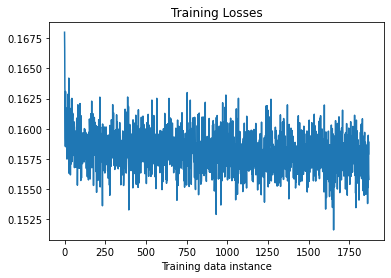

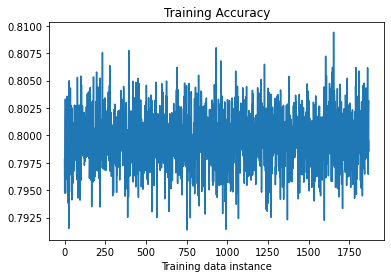

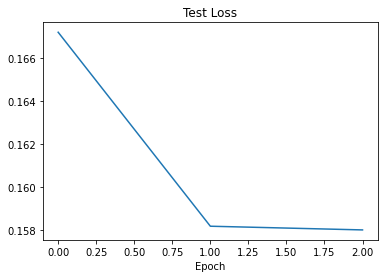

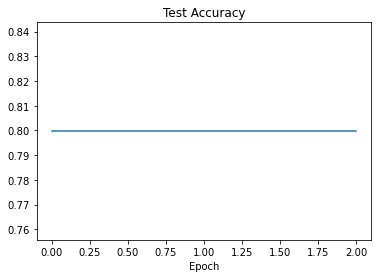

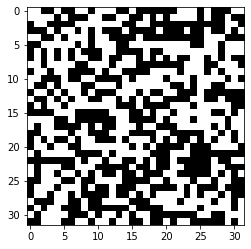

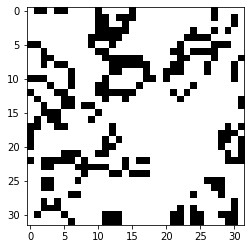

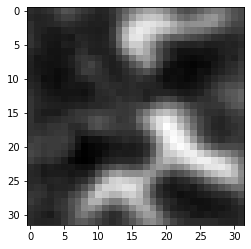

In [9]:
plt.plot(train_losses)
plt.title('Training Losses')
plt.xlabel('Training data instance')
plt.show()
plt.plot(train_accuracy)
plt.xlabel('Training data instance')
plt.title('Training Accuracy')
plt.show()
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel("Epoch")
plt.show()
plt.plot(test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

input, output = test[10]
input, output = input.unsqueeze(0).cuda(), output.unsqueeze(0).cuda()

gen_output = model(input)

input, output, gen_output = input.squeeze().cpu().detach().numpy(), output.squeeze().cpu().detach().numpy(), gen_output.squeeze().cpu().detach().numpy()
show_image(input)
show_image(output)
show_image(gen_output)

In [6]:
inputs, outputs = generate_dataset_for_step(100000, 32, 2, alpha=.5)
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)
class Step2Dataset(Dataset):
    def __init__(self, inputs, labels):
        self.data = inputs
        self.targets = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.targets[idx].unsqueeze(0)
train_batch = 128
test_batch = 128

dataset = Step2Dataset(inputs, outputs)
train, test = random_split(dataset, [int(len(dataset)*.8), len(dataset) - int(len(dataset)*.8)]) # split data 80/20
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=test_batch, drop_last=True)
print('Trainloader length:', len(train_loader))
print('Testloader length:', len(test_loader)) 

Trainloader length: 625
Testloader length: 156


In [7]:
model = SimpleConv().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.MSELoss()
num_epochs = 5
loop = tqdm(total=len(train_loader) * num_epochs, position=0)
test_losses = []
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for batch, (x, y_truth) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        train_losses.append(loss.item())
        
        accuracy = torch.sum(torch.where(torch.where(y_hat > .5, 1, 0) == y_truth, 1, 0) / torch.numel(y_truth))
        train_accuracy.append(accuracy.cpu().detach().numpy())
        if batch == 0:
            test_loss = []
            test_acc = []
            for val_x, val_y in test_loader:
                val_x, val_y = val_x.cuda(), val_y.cuda()
                y_pred = model(val_x)
                test_loss.append(objective(y_pred, val_y).item())
                test_acc.append(torch.sum(torch.where(torch.where(y_pred > .5, 1, 0) == val_y.cuda(), 1, 0) / torch.numel(val_y)).cpu().detach().numpy())
            test_losses.append(np.mean(test_loss))
            test_accuracy.append(np.mean(test_acc))

        loop.set_description('train loss: {:.4f}, train accuracy:{:.4f}, test loss: {:.4f}, test acc: {:.4f}'.format(loss.item(), accuracy, test_losses[-1], test_accuracy[-1]))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()

train loss: 0.0362, train accuracy:0.9479, test loss: 0.0356, test acc: 0.9480: 100%|██████████| 3125/3125 [08:10<00:00,  6.37it/s] 


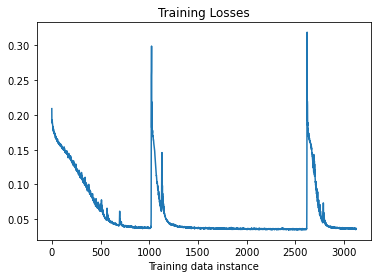

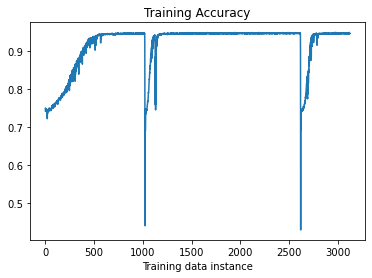

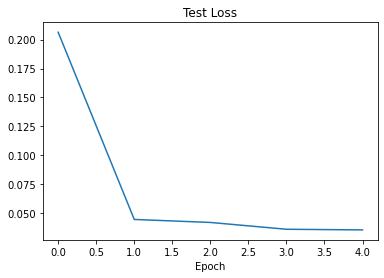

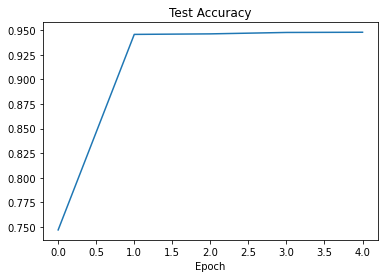

In [8]:
plt.plot(train_losses)
plt.title('Training Losses')
plt.xlabel('Training data instance')
plt.show()
plt.plot(train_accuracy)
plt.xlabel('Training data instance')
plt.title('Training Accuracy')
plt.show()
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel("Epoch")
plt.show()
plt.plot(test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

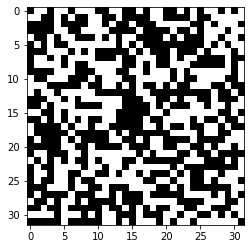

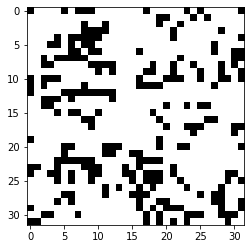

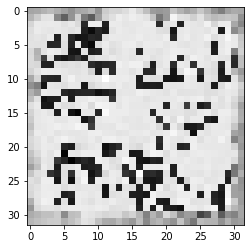

In [9]:
input, output = test[10]
input, output = input.unsqueeze(0).cuda(), output.unsqueeze(0).cuda()

gen_output = model(input)

input, output, gen_output = input.squeeze().cpu().detach().numpy(), output.squeeze().cpu().detach().numpy(), gen_output.squeeze().cpu().detach().numpy()
show_image(input)
show_image(output)
show_image(gen_output)

In [18]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, stride=2)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, stride=2)

        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu8 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(2, stride=2)

        self.conv9 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu9 = nn.ReLU()
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu10 = nn.ReLU()

        self.transpose1 = nn.ConvTranspose2d(512, 256, 2, padding=0, stride=2)
        self.conv11 = nn.Conv2d(512, 256, 3, padding=1)
        self.relu11 = nn.ReLU()
        self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu12 = nn.ReLU()

        self.transpose2 = nn.ConvTranspose2d(256, 128, 2, padding=0, stride=2)
        self.conv13 = nn.Conv2d(256, 128, 3, padding=1)
        self.relu13 = nn.ReLU()
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu14 = nn.ReLU()

        self.transpose3 = nn.ConvTranspose2d(128, 64, 2, padding=0, stride=2)
        self.conv15 = nn.Conv2d(128, 64, 3, padding=1)
        self.relu15 = nn.ReLU()
        self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu16 = nn.ReLU()

        self.transpose4 = nn.ConvTranspose2d(64, 32, 2, padding=0, stride=2)
        self.conv17 = nn.Conv2d(64, 32, 3, padding=1)
        self.relu17 = nn.ReLU()
        self.conv18 = nn.Conv2d(32, 32, 3, padding=1)
        self.relu18 = nn.ReLU()
        self.finalconv = nn.Conv2d(32, 1, 1, padding=0)

    def forward(self, x):
        conv1_out = self.conv1(x)
        relu1_out = self.relu1(conv1_out)
        conv2_out = self.conv2(relu1_out)
        relu2_out = self.relu2(conv2_out) # fourth to concat
        # 
        maxpool1_out = self.maxpool1(relu2_out)
        conv3_out = self.conv3(maxpool1_out)
        relu3_out = self.relu3(conv3_out)
        conv4_out = self.conv4(relu3_out)
        relu4_out = self.relu4(conv4_out) # third to concat

        maxpool2_out = self.maxpool2(relu4_out)
        conv5_out = self.conv5(maxpool2_out)
        relu5_out = self.relu5(conv5_out)
        conv6_out = self.conv6(relu5_out)
        relu6_out = self.relu6(conv6_out) # second to concat


        maxpool3_out = self.maxpool3(relu6_out)
        conv7_out = self.conv7(maxpool3_out)
        relu7_out = self.relu7(conv7_out)
        conv8_out = self.conv8(relu7_out)
        relu8_out = self.relu8(conv8_out) # first to concat

        maxpool4_out = self.maxpool4(relu8_out)
        conv9_out = self.conv9(maxpool4_out)
        relu9_out = self.relu9(conv9_out)
        conv10_out = self.conv10(relu9_out)
        transpose1_out = self.transpose1(conv10_out)
        concat1 = torch.cat((relu8_out, transpose1_out), dim=1)

        conv11_out = self.conv11(concat1)
        relu11_out = self.relu11(conv11_out)
        conv12_out = self.conv12(relu11_out)
        relu12_out = self.relu12(conv12_out)
        transpose2_out = self.transpose2(relu12_out)
        concat2 = torch.cat((relu6_out, transpose2_out), dim=1)

        conv13_out = self.conv13(concat2)
        relu13_out = self.relu13(conv13_out)
        conv14_out = self.conv14(relu13_out)
        relu14_out = self.relu14(conv14_out)
        transpose3_out = self.transpose3(relu14_out)
        concat3 = torch.cat((relu4_out, transpose3_out), dim=1)

        conv15_out = self.conv15(concat3)
        relu15_out = self.relu15(conv15_out)
        conv16_out = self.conv16(relu15_out)
        relu16_out = self.relu16(conv16_out)
        transpose4_out = self.transpose4(relu16_out)
        concat4 = torch.cat((relu2_out, transpose4_out), dim=1)

        conv17_out = self.conv17(concat4)
        relu17_out = self.relu17(conv17_out)
        conv18_out = self.conv18(relu17_out)
        relu18_out = self.relu18(conv18_out)
        finalconv_out = self.finalconv(relu18_out)
        return finalconv_out


In [19]:
inputs, outputs = generate_dataset_for_step(100000, 32, 1, alpha=.5)
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)
dataset = Step1Dataset(inputs, outputs)
train, test = random_split(dataset, [int(len(dataset)*.8), len(dataset) - int(len(dataset)*.8)]) # split data 80/20
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=test_batch, drop_last=True)
print('Trainloader length:', len(train_loader))
print('Testloader length:', len(test_loader))

Trainloader length: 625
Testloader length: 156


In [20]:
model = UNet().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.MSELoss()
num_epochs = 5
loop = tqdm(total=len(train_loader) * num_epochs, position=0)
test_losses = []
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for batch, (x, y_truth) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        train_losses.append(loss.item())
        
        accuracy = torch.sum(torch.where(torch.where(y_hat > .5, 1, 0) == y_truth, 1, 0) / torch.numel(y_truth))
        train_accuracy.append(accuracy.cpu().detach().numpy())
        if batch == 0:
            test_loss = []
            test_acc = []
            for val_x, val_y in test_loader:
                val_x, val_y = val_x.cuda(), val_y.cuda()
                y_pred = model(val_x)
                test_loss.append(objective(y_pred, val_y).item())
                test_acc.append(torch.sum(torch.where(torch.where(y_pred > .5, 1, 0) == val_y.cuda(), 1, 0) / torch.numel(val_y)).cpu().detach().numpy())
            test_losses.append(np.mean(test_loss))
            test_accuracy.append(np.mean(test_acc))

        loop.set_description('train loss: {:.4f}, train accuracy:{:.4f}, test loss: {:.4f}, test acc: {:.4f}'.format(loss.item(), accuracy, test_losses[-1], test_accuracy[-1]))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()


train loss: 0.7425, train accuracy:0.2575, test loss: 0.7467, test acc: 0.2533:  60%|██████    | 1875/3125 [01:37<01:04, 19.28it/s]
train loss: 0.0181, train accuracy:0.9729, test loss: 0.0189, test acc: 0.9715: 100%|██████████| 3125/3125 [02:08<00:00, 24.29it/s]


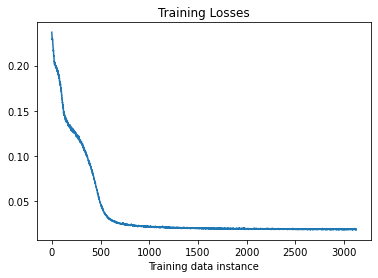

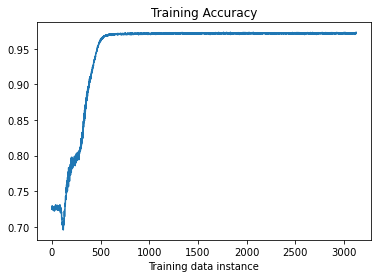

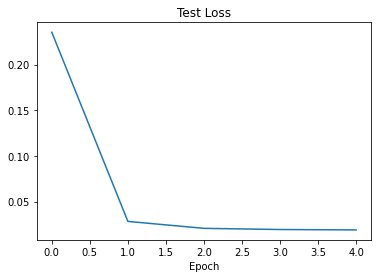

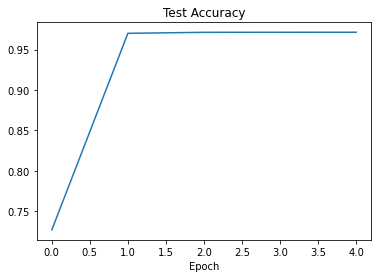

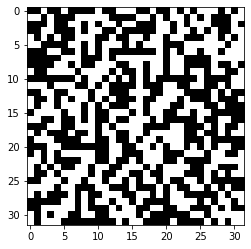

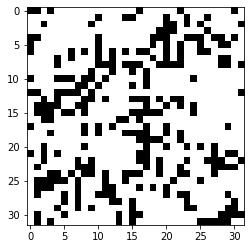

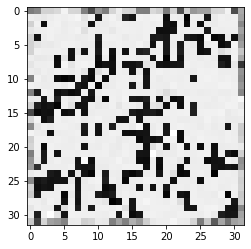

In [21]:
plt.plot(train_losses)
plt.title('Training Losses')
plt.xlabel('Training data instance')
plt.show()
plt.plot(train_accuracy)
plt.xlabel('Training data instance')
plt.title('Training Accuracy')
plt.show()
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel("Epoch")
plt.show()
plt.plot(test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

input, output = test[10]
input, output = input.unsqueeze(0).cuda(), output.unsqueeze(0).cuda()

gen_output = model(input)

input, output, gen_output = input.squeeze().cpu().detach().numpy(), output.squeeze().cpu().detach().numpy(), gen_output.squeeze().cpu().detach().numpy()
show_image(input)
show_image(output)
show_image(gen_output)

In [22]:
inputs, outputs = generate_dataset_for_step(100000, 32, 2, alpha=.5)
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)
dataset = Step1Dataset(inputs, outputs)
train, test = random_split(dataset, [int(len(dataset)*.8), len(dataset) - int(len(dataset)*.8)]) # split data 80/20
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=test_batch, drop_last=True)
print('Trainloader length:', len(train_loader))
print('Testloader length:', len(test_loader)) 

Trainloader length: 625
Testloader length: 156


In [26]:
model = UNet().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.MSELoss()
num_epochs = 15
loop = tqdm(total=len(train_loader) * num_epochs, position=0)
test_losses = []
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for batch, (x, y_truth) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        train_losses.append(loss.item())
        
        accuracy = torch.sum(torch.where(torch.where(y_hat > .5, 1, 0) == y_truth, 1, 0) / torch.numel(y_truth))
        train_accuracy.append(accuracy.cpu().detach().numpy())
        if batch == 0:
            test_loss = []
            test_acc = []
            for val_x, val_y in test_loader:
                val_x, val_y = val_x.cuda(), val_y.cuda()
                y_pred = model(val_x)
                test_loss.append(objective(y_pred, val_y).item())
                test_acc.append(torch.sum(torch.where(torch.where(y_pred > .5, 1, 0) == val_y.cuda(), 1, 0) / torch.numel(val_y)).cpu().detach().numpy())
            test_losses.append(np.mean(test_loss))
            test_accuracy.append(np.mean(test_acc))

        loop.set_description('train loss: {:.4f}, train accuracy:{:.4f}, test loss: {:.4f}, test acc: {:.4f}'.format(loss.item(), accuracy, test_losses[-1], test_accuracy[-1]))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()


train loss: 0.0381, train accuracy:0.9473, test loss: 0.0391, test acc: 0.9464: 100%|██████████| 9375/9375 [07:10<00:00, 21.76it/s]


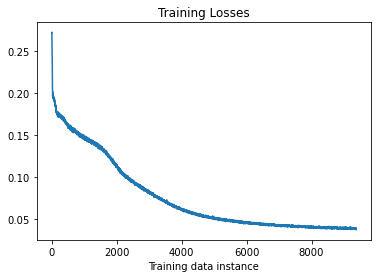

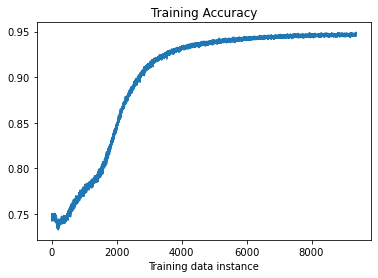

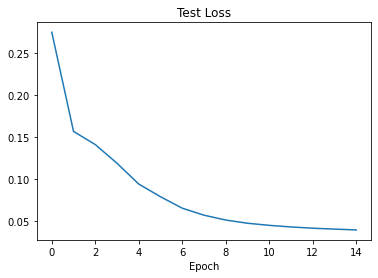

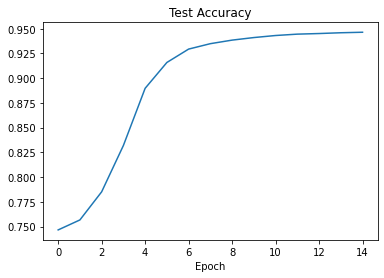

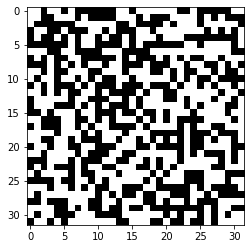

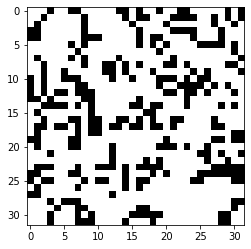

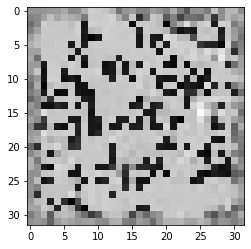

In [27]:
plt.plot(train_losses)
plt.title('Training Losses')
plt.xlabel('Training data instance')
plt.show()
plt.plot(train_accuracy)
plt.xlabel('Training data instance')
plt.title('Training Accuracy')
plt.show()
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel("Epoch")
plt.show()
plt.plot(test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

input, output = test[10]
input, output = input.unsqueeze(0).cuda(), output.unsqueeze(0).cuda()

gen_output = model(input)

input, output, gen_output = input.squeeze().cpu().detach().numpy(), output.squeeze().cpu().detach().numpy(), gen_output.squeeze().cpu().detach().numpy()
show_image(input)
show_image(output)
show_image(gen_output)


In [29]:
inputs, outputs = generate_dataset_for_step(100000, 32, 10, alpha=.5)
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs)
dataset = Step1Dataset(inputs, outputs)
train, test = random_split(dataset, [int(len(dataset)*.8), len(dataset) - int(len(dataset)*.8)]) # split data 80/20
train_loader = DataLoader(train, batch_size=train_batch, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=test_batch, drop_last=True)
print('Trainloader length:', len(train_loader))
print('Testloader length:', len(test_loader)) 

Trainloader length: 625
Testloader length: 156


In [30]:
model = UNet().cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = torch.nn.MSELoss()
num_epochs = 15
loop = tqdm(total=len(train_loader) * num_epochs, position=0)
test_losses = []
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    for batch, (x, y_truth) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y_truth = x.cuda(), y_truth.cuda()
        y_hat = model(x)
        loss = objective(y_hat, y_truth)
        train_losses.append(loss.item())
        
        accuracy = torch.sum(torch.where(torch.where(y_hat > .5, 1, 0) == y_truth, 1, 0) / torch.numel(y_truth))
        train_accuracy.append(accuracy.cpu().detach().numpy())
        if batch == 0:
            test_loss = []
            test_acc = []
            for val_x, val_y in test_loader:
                val_x, val_y = val_x.cuda(), val_y.cuda()
                y_pred = model(val_x)
                test_loss.append(objective(y_pred, val_y).item())
                test_acc.append(torch.sum(torch.where(torch.where(y_pred > .5, 1, 0) == val_y.cuda(), 1, 0) / torch.numel(val_y)).cpu().detach().numpy())
            test_losses.append(np.mean(test_loss))
            test_accuracy.append(np.mean(test_acc))

        loop.set_description('train loss: {:.4f}, train accuracy:{:.4f}, test loss: {:.4f}, test acc: {:.4f}'.format(loss.item(), accuracy, test_losses[-1], test_accuracy[-1]))
        loop.update(1)

        loss.backward()
        optimizer.step()
        batch += 1

loop.close()


train loss: 0.1575, train accuracy:0.8005, test loss: 0.1582, test acc: 0.7996: 100%|██████████| 9375/9375 [06:56<00:00, 22.52it/s]


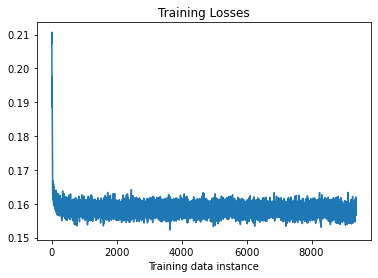

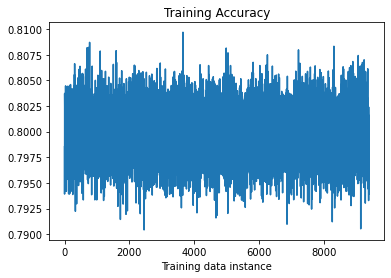

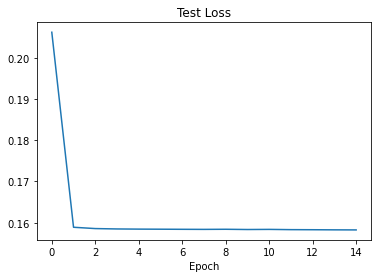

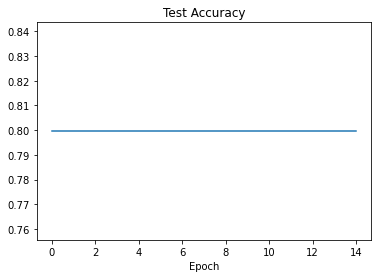

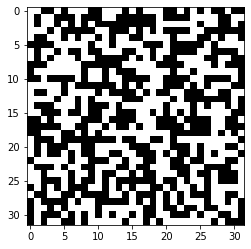

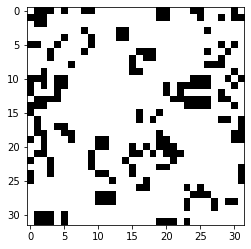

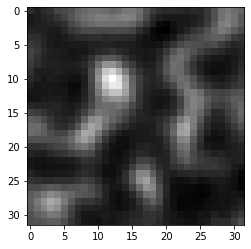

In [31]:
plt.plot(train_losses)
plt.title('Training Losses')
plt.xlabel('Training data instance')
plt.show()
plt.plot(train_accuracy)
plt.xlabel('Training data instance')
plt.title('Training Accuracy')
plt.show()
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel("Epoch")
plt.show()
plt.plot(test_accuracy)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

input, output = test[10]
input, output = input.unsqueeze(0).cuda(), output.unsqueeze(0).cuda()

gen_output = model(input)

input, output, gen_output = input.squeeze().cpu().detach().numpy(), output.squeeze().cpu().detach().numpy(), gen_output.squeeze().cpu().detach().numpy()
show_image(input)
show_image(output)
show_image(gen_output)